In [7]:
import xgboost as xgb
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.inspection import permutation_importance
from sklearn import svm

In [95]:
df = pd.read_csv("Dataset4.csv")
df.dropna(inplace = True)
df

,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,target
0,38667.0,1883.0,tcp,mqtt,32.011598,9.0,5.0,3.0,3.0,0.281148,...,0.0,29729182.96,29729182.96,29729182.96,29729182.96,0.0,64240.0,26847.0,502.0,MQTT_Publish
2,44761.0,1883.0,tcp,mqtt,32.124053,9.0,5.0,3.0,3.0,0.280164,...,0.0,29842149.02,29842149.02,29842149.02,29842149.02,0.0,64240.0,26847.0,502.0,MQTT_Publish
3,60893.0,1883.0,tcp,mqtt,31.961063,9.0,5.0,3.0,3.0,0.281593,...,0.0,29913774.97,29913774.97,29913774.97,29913774.97,0.0,64240.0,26847.0,502.0,MQTT_Publish
4,51087.0,1883.0,tcp,mqtt,31.902362,9.0,5.0,3.0,3.0,0.282111,...,0.0,29814704.90,29814704.90,29814704.90,29814704.90,0.0,64240.0,26847.0,502.0,MQTT_Publish
5,48579.0,1883.0,tcp,mqtt,31.869686,9.0,5.0,3.0,3.0,0.282400,...,0.0,29825548.17,29825548.17,29825548.17,29825548.17,0.0,64240.0,26847.0,502.0,MQTT_Publish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123112,59247.0,63331.0,tcp,-,0.000006,1.0,1.0,0.0,0.0,167772.160000,...,0.0,0.00,0.00,0.00,0.00,0.0,1024.0,0.0,1024.0,NMAP_XMAS_TREE_SCAN
123113,59247.0,64623.0,tcp,-,0.000007,1.0,1.0,0.0,0.0,144631.172400,...,0.0,0.00,0.00,0.00,0.00,0.0,1024.0,0.0,1024.0,NMAP_XMAS_TREE_SCAN
123114,59247.0,64680.0,tcp,-,0.000006,1.0,1.0,0.0,0.0,167772.160000,...,0.0,0.00,0.00,0.00,0.00,0.0,1024.0,0.0,1024.0,NMAP_XMAS_TREE_SCAN
123115,59247.0,65000.0,tcp,-,0.000006,1.0,1.0,0.0,0.0,167772.160000,...,0.0,0.00,0.00,0.00,0.00,0.0,1024.0,0.0,1024.0,NMAP_XMAS_TREE_SCAN


#### Label the data

In [96]:
label_encoder = LabelEncoder()
df.target = label_encoder.fit_transform(df.target)
df.proto = label_encoder.fit_transform(df.proto)
df.service = label_encoder.fit_transform(df.service)

#### Data Scaling

In [65]:
X_to_scale = df.drop(columns = {"proto", "service"})
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_to_scale)
X_scaled_df = pd.DataFrame(X_scaled, columns = X_to_scale.columns)

#### X and Y variables splitting

In [66]:
X = X_scaled_df
X['proto'] = df['proto']
X['service'] = df['service']
X['target'] = df.target
X.dropna(inplace = True)
y = X.target
X.drop(columns = 'target', inplace = True)
X.shape

(122519, 83)

### Peformance metrics

In [67]:
def performance_metric(y_test, y_pred):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print( confusion_matrix(y_test, y_pred))

## Feature importance approach

### Gini Approach

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [14]:
ft_importance = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': ft_importance
}).sort_values(by='Importance', ascending=False)

In [15]:
feature_importance_df

,Feature,Importance
1,id.resp_p,0.076202
29,fwd_pkts_payload.min,0.067387
32,fwd_pkts_payload.avg,0.066587
62,fwd_subflow_bytes,0.057561
31,fwd_pkts_payload.tot,0.042386
...,...,...
68,fwd_bulk_rate,0.000022
79,idle.std,0.000021
64,fwd_bulk_bytes,0.000014
66,fwd_bulk_packets,0.000013


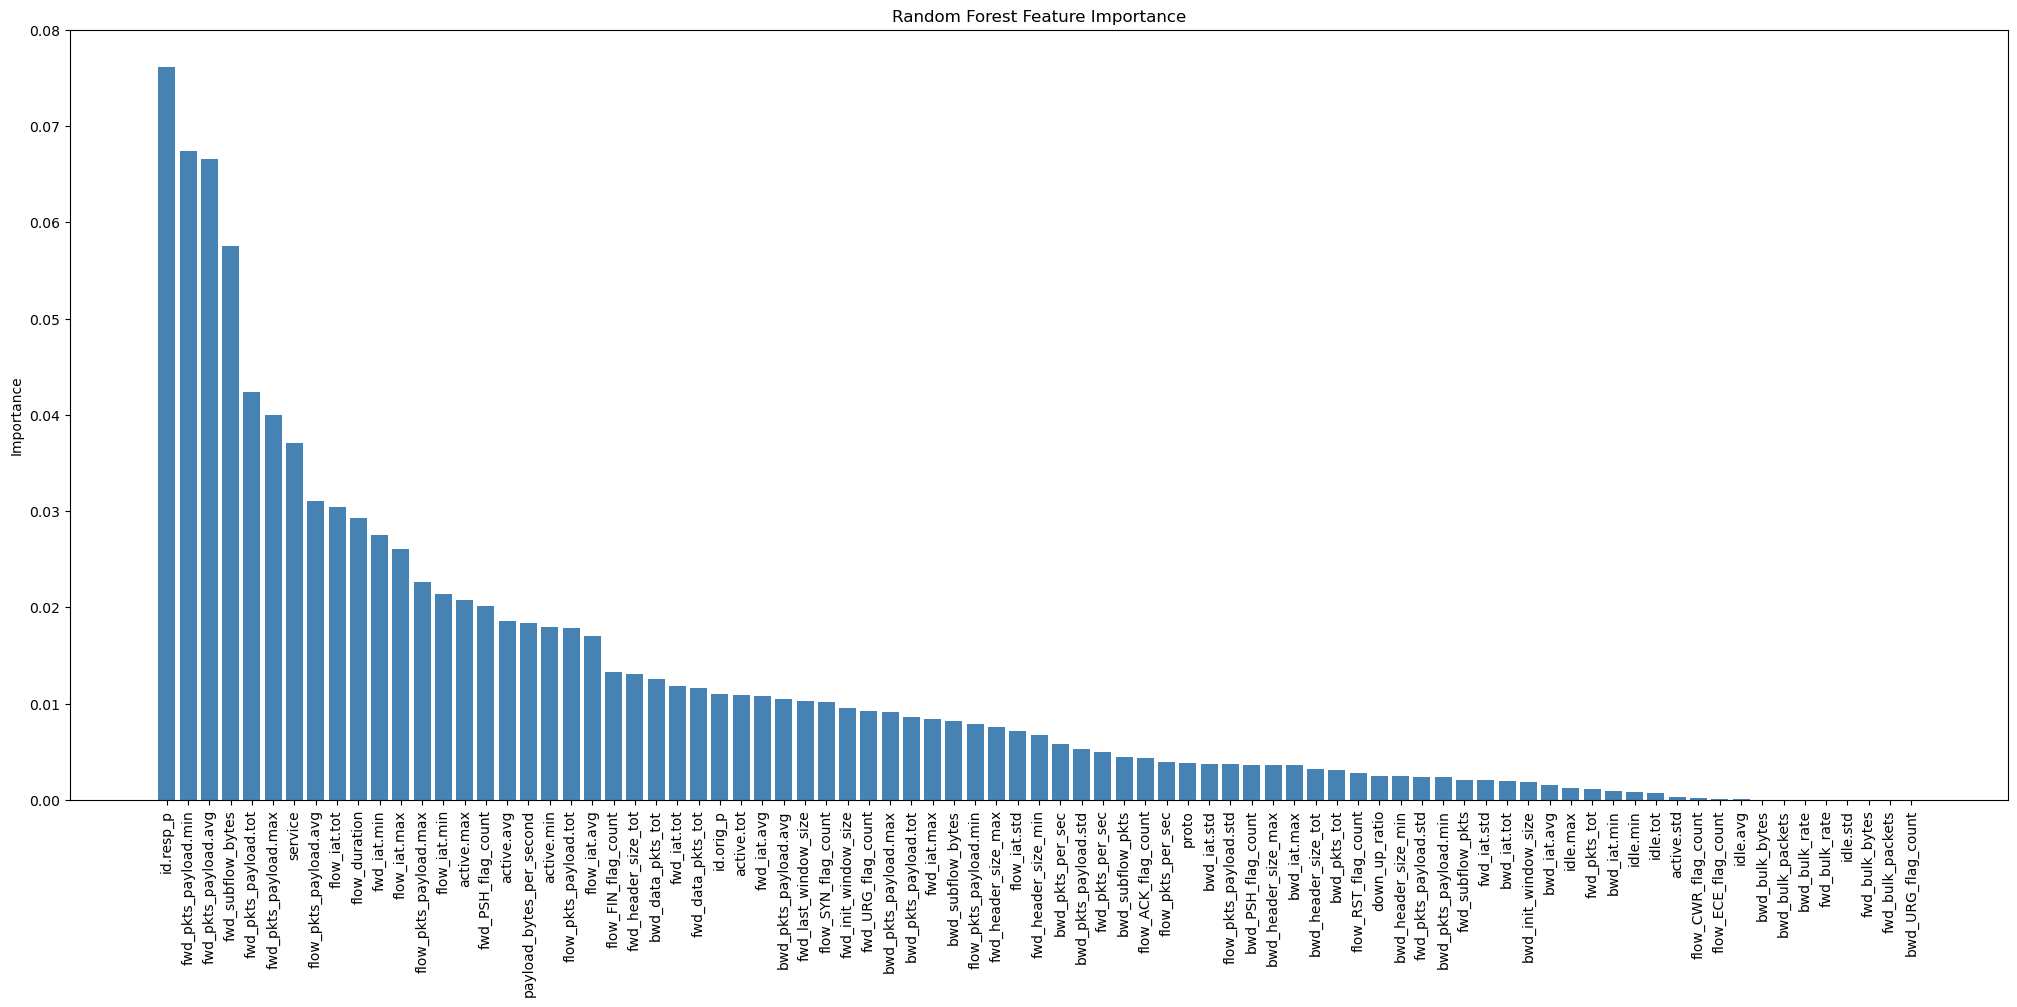

In [73]:
plt.figure(figsize = (25,10))
plt.bar(feature_importance_df["Feature"],feature_importance_df['Importance'], color='steelblue')
plt.title('Random Forest Feature Importance')
plt.ylabel('Importance')
plt.xticks( rotation=90)  # Rotate x-axis labels
plt.show()

## SHAP approach

In [36]:
# Create a SHAP TreeExplainer for the trained Random Forest model
explainer = shap.TreeExplainer(rf_model)

# Generate SHAP values for the test dataset
shap_values = explainer.shap_values(X_test)

# Initialize a dictionary to store the mean absolute SHAP values for each class
mean_shap_importance = {}

# Loop through each class in the output
for class_index in range(shap_values.shape[2]):  # Total number of classes
    # Compute the mean absolute SHAP values for the current class
    mean_shap_values = np.abs(shap_values[:, :, class_index]).mean(axis=0)
    mean_shap_importance[class_index] = mean_shap_values

# Convert the dictionary of mean SHAP values into a DataFrame, using feature names as the index
feature_importance_shap = pd.DataFrame(mean_shap_importance)
feature_importance_shap.index = X_test.columns

# Calculate the overall importance of features by averaging the SHAP values across all classes
overall_importance = feature_importance_shap.mean(axis=1)

# Create a new DataFrame to hold the overall feature importance values
overall_importance_df = pd.DataFrame({
    'Feature': overall_importance.index,
    'Mean Absolute SHAP Value': overall_importance.values
})

# Sort the DataFrame by the mean absolute SHAP values in descending order
overall_importance_df = overall_importance_df.sort_values(by='Mean Absolute SHAP Value', ascending=False)


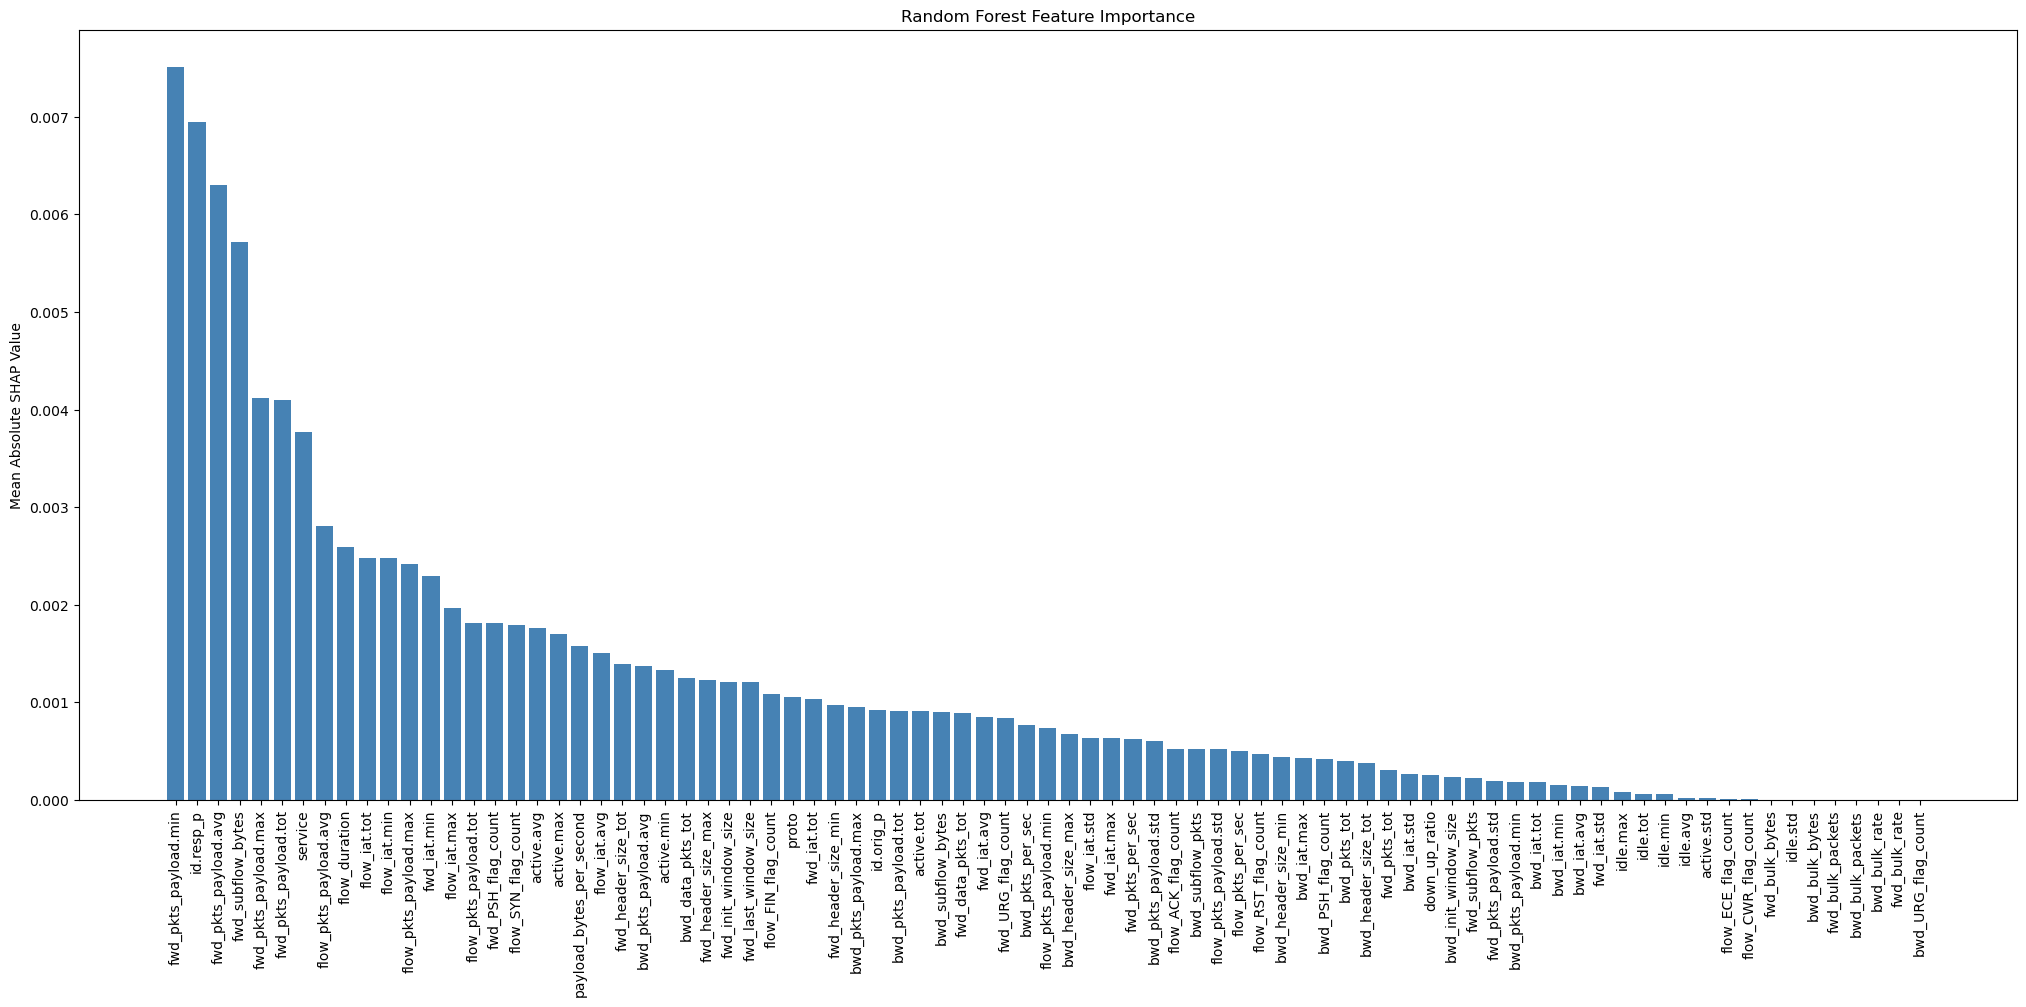

In [109]:
plt.figure(figsize = (25,10))
plt.bar(overall_importance_df["Feature"],overall_importance_df['Mean Absolute SHAP Value'], color='steelblue')
plt.title('Random Forest Feature Importance')
plt.ylabel('Mean Absolute SHAP Value')
plt.xticks( rotation=90)  # Rotate x-axis labels
plt.show()


In Random Forests, importance scores are typically higher, indicating that certain features are heavily weighted in predictions (e.g., the highest score is 0.077). Conversely, SHAP values are generally lower, with the highest being 0.0075, as they reflect the average contribution of each feature across predictions, focusing on individual contributions rather than overall model behavior.

Both models identify id.resp_p, fwd_pkts_payload.min, and fwd_pkts_payload.avg as the most influential features, while fwd_bulk_packets, fwd_bulk_rate, and bwd_URG_flag_count have the least impact. This alignment suggests that both models recognize these features as important.

### Permuation Approach

In [94]:
df

,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,...,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
0,38667.0,1883.0,1,5,32.011598,9.0,5.0,3.0,3.0,0.281148,...,2.282415e+06,0.0,29729182.96,29729182.96,29729182.96,29729182.96,0.0,64240.0,26847.0,502.0
2,44761.0,1883.0,1,5,32.124053,9.0,5.0,3.0,3.0,0.280164,...,2.281904e+06,0.0,29842149.02,29842149.02,29842149.02,29842149.02,0.0,64240.0,26847.0,502.0
3,60893.0,1883.0,1,5,31.961063,9.0,5.0,3.0,3.0,0.281593,...,2.047288e+06,0.0,29913774.97,29913774.97,29913774.97,29913774.97,0.0,64240.0,26847.0,502.0
4,51087.0,1883.0,1,5,31.902362,9.0,5.0,3.0,3.0,0.282111,...,2.087657e+06,0.0,29814704.90,29814704.90,29814704.90,29814704.90,0.0,64240.0,26847.0,502.0
5,48579.0,1883.0,1,5,31.869686,9.0,5.0,3.0,3.0,0.282400,...,2.044138e+06,0.0,29825548.17,29825548.17,29825548.17,29825548.17,0.0,64240.0,26847.0,502.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123112,59247.0,63331.0,1,0,0.000006,1.0,1.0,0.0,0.0,167772.160000,...,5.960464e+00,0.0,0.00,0.00,0.00,0.00,0.0,1024.0,0.0,1024.0
123113,59247.0,64623.0,1,0,0.000007,1.0,1.0,0.0,0.0,144631.172400,...,6.914139e+00,0.0,0.00,0.00,0.00,0.00,0.0,1024.0,0.0,1024.0
123114,59247.0,64680.0,1,0,0.000006,1.0,1.0,0.0,0.0,167772.160000,...,5.960464e+00,0.0,0.00,0.00,0.00,0.00,0.0,1024.0,0.0,1024.0
123115,59247.0,65000.0,1,0,0.000006,1.0,1.0,0.0,0.0,167772.160000,...,5.960464e+00,0.0,0.00,0.00,0.00,0.00,0.0,1024.0,0.0,1024.0


In [106]:
X_train_or, X_test_or, y_train_or, y_test_or = train_test_split(df.iloc[:,:-1], df.target, test_size=0.2, random_state=1)
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)
rf_model.fit(X_train_or, y_train_or)

RandomForestClassifier(random_state=1)

In [107]:
# Compute permutation importance
result = permutation_importance(rf_model, X_test_or, y_test_or, random_state=42)

# Store feature importances in a DataFrame
importance_df = pd.DataFrame({
    'Feature': df.iloc[:,:-1].columns,  # Assuming X is a DataFrame
    'Importance': result.importances_mean})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

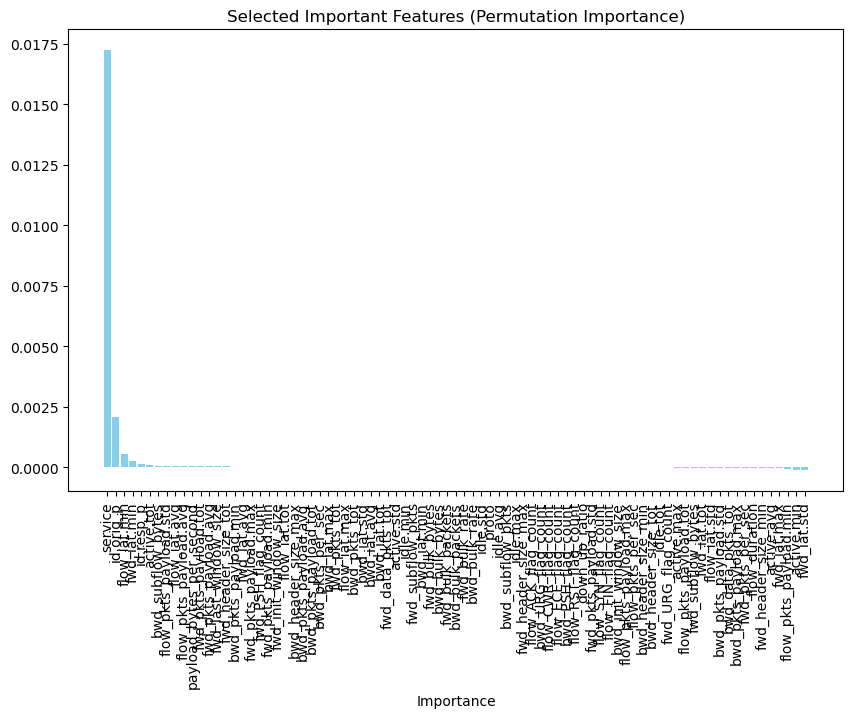

In [108]:

# Optional: Visualize the selected important features
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Selected Important Features (Permutation Importance)')
plt.xticks( rotation=90)  # Rotate x-axis labels
plt.show()

## Dimensionality Reduction

In [68]:
# Apply PCA
pca = PCA(n_components=None)  # Compute all components
pca.fit(X)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

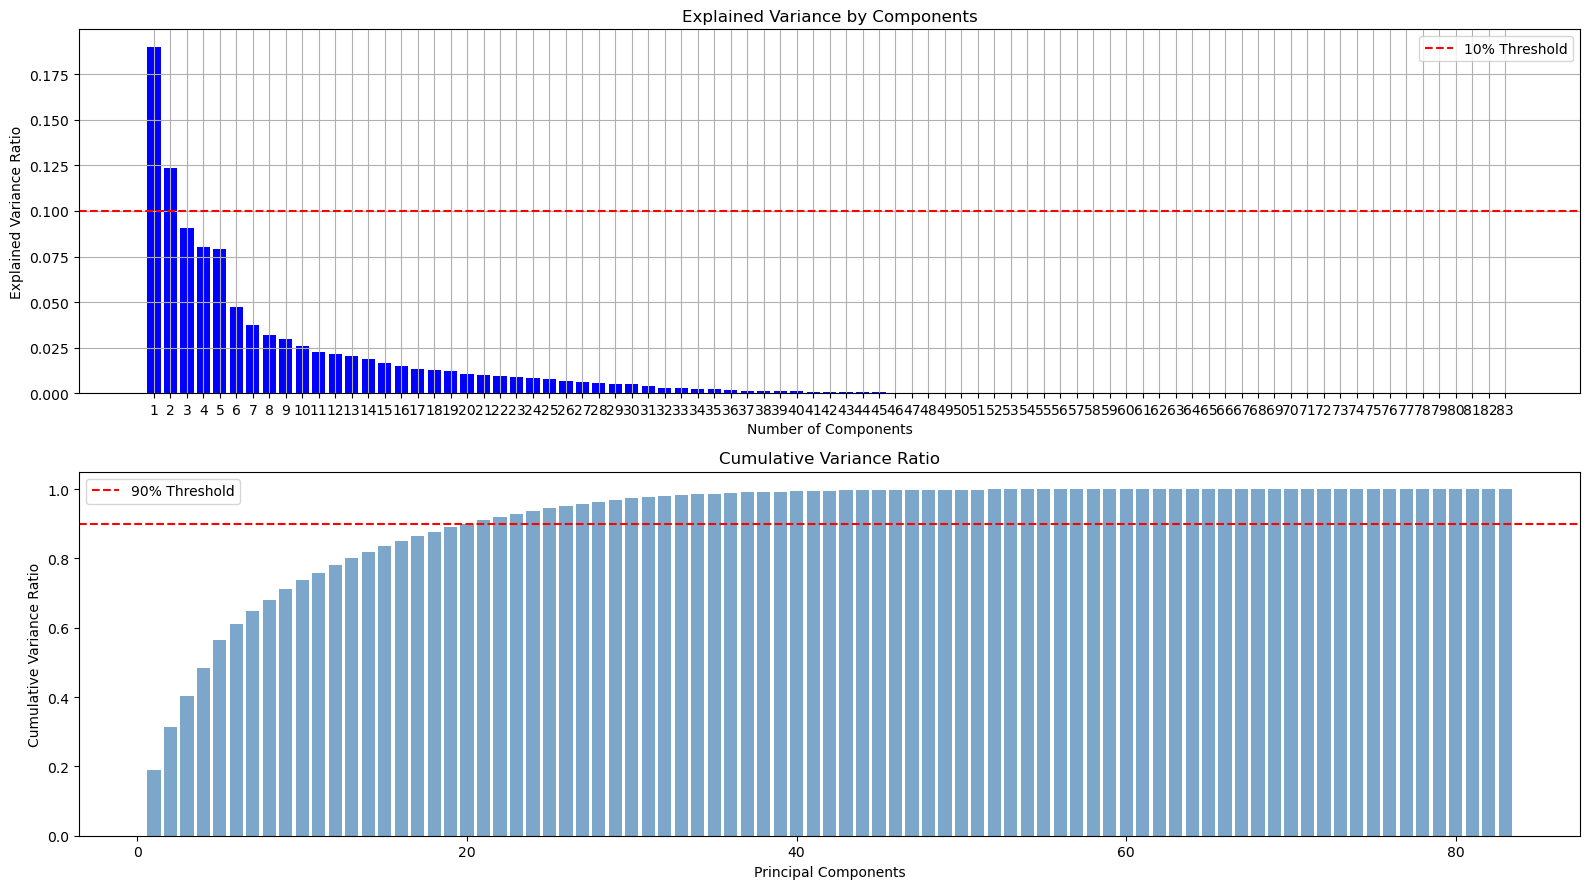

In [76]:
#### Create subplots for explained variance and cumulative variance ratio
fig, axs = plt.subplots(2, 1, figsize=(16, 9))  # 1 row, 2 columns
components = np.arange(1, len(explained_variance_ratio) + 1)  # Generate an array of component numbers

# Plot explained variance on the first subplot
axs[0].bar(components, explained_variance_ratio,color="blue")
axs[0].set_title('Explained Variance by Components')  # Title of the first plot
axs[0].set_xlabel('Number of Components')  # X-axis label
axs[0].set_ylabel('Explained Variance Ratio')  # Y-axis label
axs[0].set_xticks(components)  # X-ticks
axs[0].axhline(y=0.10, color='red', linestyle='--', label='10% Threshold')  # Add a threshold line
axs[0].grid()  # Enable grid for better readability
axs[0].legend()  # Show legend for the threshold line

# Plot cumulative variance ratio on the second subplot
axs[1].bar(components, cumulative_variance_ratio, color='steelblue', alpha=0.7)  # Bar chart for cumulative variance ratio
axs[1].set_xlabel('Principal Components')  # X-axis label
axs[1].set_ylabel('Cumulative Variance Ratio')  # Y-axis label
axs[1].axhline(y=0.90, color='red', linestyle='--', label='90% Threshold')  # Add a threshold line
axs[1].set_title('Cumulative Variance Ratio')  # Title of the second plot
axs[1].legend()  # Show the legend for the threshold line

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()  # Display the combined plots


In [126]:
pca = PCA(n_components=20)  # Reduce to 2 dimensions
X_pca = pca.fit_transform(X)
pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(20)])

In [127]:
X_train, X_test, y_train, y_test = train_test_split(pca_df, y, test_size=0.3, random_state=42)

### KNN model

#### Hyperparameters tunning

In [25]:
param_grid_dist = {
    'n_neighbors': range(1, 21),
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
knn_distance = KNeighborsClassifier()
grid_search_dist = GridSearchCV(knn_distance,param_grid = param_grid_dist, cv=5, verbose = 3)  # 5-fold cross-validation
grid_search_dist.fit(X_train, y_train)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END ...metric=euclidean, n_neighbors=1;, score=0.992 total time=   1.4s
[CV 2/5] END ...metric=euclidean, n_neighbors=1;, score=0.991 total time=   1.4s
[CV 3/5] END ...metric=euclidean, n_neighbors=1;, score=0.991 total time=   1.4s
[CV 4/5] END ...metric=euclidean, n_neighbors=1;, score=0.993 total time=   1.4s
[CV 5/5] END ...metric=euclidean, n_neighbors=1;, score=0.991 total time=   1.4s
[CV 1/5] END ...metric=euclidean, n_neighbors=2;, score=0.990 total time=   1.4s
[CV 2/5] END ...metric=euclidean, n_neighbors=2;, score=0.990 total time=   1.4s
[CV 3/5] END ...metric=euclidean, n_neighbors=2;, score=0.989 total time=   1.4s
[CV 4/5] END ...metric=euclidean, n_neighbors=2;, score=0.990 total time=   1.4s
[CV 5/5] END ...metric=euclidean, n_neighbors=2;, score=0.991 total time=   1.4s
[CV 1/5] END ...metric=euclidean, n_neighbors=3;, score=0.990 total time=   1.4s
[CV 2/5] END ...metric=euclidean, n_neighbors=3

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': range(1, 21)},
             verbose=3)

In [26]:
print("Best parameters found:", grid_search_dist.best_params_)
print("Best cross-validation score:", grid_search_dist.best_score_)

Best parameters found: {'metric': 'manhattan', 'n_neighbors': 1}
Best cross-validation score: 0.9917680236682413


#### KNN model fitting

In [103]:
knn_model = KNeighborsClassifier( metric = 'manhattan', n_neighbors = 1)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

performance_metric(y_test, y_pred_knn)

Accuracy: 0.9915387963869844
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      2311
         1.0       0.99      0.99      0.99       158
         2.0       1.00      1.00      1.00     28342
         3.0       1.00      1.00      1.00      1266
         4.0       0.85      0.92      0.88        12
         5.0       0.08      0.20      0.11         5
         6.0       0.89      0.88      0.89       627
         7.0       0.96      0.93      0.94       300
         8.0       0.97      0.97      0.97       741
         9.0       0.99      0.98      0.99       503
        10.0       0.98      0.98      0.98      2419
        11.0       0.84      0.67      0.74        72

    accuracy                           0.99     36756
   macro avg       0.88      0.87      0.87     36756
weighted avg       0.99      0.99      0.99     36756



### SVM model

#### Hyperparameters

In [20]:
# defining parameter range 
param_grid = {'C': [0.01, 0.1, 0.001, 1, 10, 100, 1000],
              'gamma': [0.1, 0.01, 0.001, 0.0001, 0.00001]}  
  
grid_rbf = GridSearchCV(svm.SVC(), param_grid, verbose = 3, n_jobs = -1)
  
# fitting the model for grid search 
grid_rbf.fit(X_train, y_train) 

Fitting 5 folds for each of 35 candidates, totalling 175 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 0.001, 1, 10, 100, 1000],
                         'gamma': [0.1, 0.01, 0.001, 0.0001, 1e-05]},
             verbose=3)

In [23]:
print("Best parameters found:", grid_rbf.best_params_)
print("Best cross-validation score:", grid_rbf.best_score_)

Best parameters found: {'C': 1000, 'gamma': 0.1}
Best cross-validation score: 0.9924093238226463


#### SVM fitting 

In [104]:
svm_rbf = svm.SVC(kernel = 'rbf', C = 1000, gamma = 0.1)
svm_rbf.fit(X_train, y_train)

y_pred_rbf = svm_rbf.predict(X_test)
performance_metric(y_test, y_pred_rbf)

Accuracy: 0.9933888344760039
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      2311
         1.0       1.00      0.99      0.99       158
         2.0       1.00      1.00      1.00     28342
         3.0       1.00      0.99      1.00      1266
         4.0       0.85      0.92      0.88        12
         5.0       0.17      0.20      0.18         5
         6.0       0.89      0.99      0.94       627
         7.0       0.99      0.98      0.98       300
         8.0       0.98      0.99      0.98       741
         9.0       1.00      0.99      1.00       503
        10.0       0.98      0.98      0.98      2419
        11.0       0.95      0.51      0.67        72

    accuracy                           0.99     36756
   macro avg       0.90      0.88      0.88     36756
weighted avg       0.99      0.99      0.99     36756



### Logistic Regression

#### Hyper-parameters tunning

In [34]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'sag', 'saga'],
    'multi_class': ['multinomial']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, cv=5, verbose = 3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 5/5] END C=0.001, multi_class=multinomial, solver=newton-cg;, score=0.963 total time=   9.4s
[CV 3/5] END C=0.001, multi_class=multinomial, solver=saga;, score=0.965 total time= 2.0min
[CV 5/5] END C=0.1, multi_class=multinomial, solver=saga;, score=0.968 total time= 3.3min
[CV 4/5] END C=1, multi_class=multinomial, solver=saga;, score=0.968 total time= 3.7min
[CV 2/5] END C=10, multi_class=multinomial, solver=sag;, score=0.969 total time= 4.4min
[CV 2/5] END C=100, multi_class=multinomial, solver=sag;, score=0.969 total time= 5.3min
[CV 3/5] END C=0.001, multi_class=multinomial, solver=sag;, score=0.965 total time= 1.4min
[CV 3/5] END C=0.1, multi_class=multinomial, solver=sag;, score=0.968 total time= 3.7min
[CV 5/5] END C=1, multi_class=multinomial, solver=sag;, score=0.969 total time= 4.3min
[CV 3/5] END C=10, multi_class=multinomial, solver=saga;, score=0.968 total time= 4.3min
[CV 1/5] END C=100, multi_class=multino

In [35]:
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters found: {'C': 100, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
Best cross-validation score: 0.9759686465086826


#### Logistic regression fitting 

In [105]:
# Initialize the Logistic Regression model
logistic_model = LogisticRegression(max_iter=5000, C = 100, multi_class = 'multinomial', solver = 'newton-cg') 
# Train the model
logistic_model.fit(X_train, y_train)

# Predict the target variable
y_pred_lg = logistic_model.predict(X_test)
performance_metric(y_test, y_pred_lg)

Accuracy: 0.9763576014800305
              precision    recall  f1-score   support

         0.0       0.90      0.84      0.87      2311
         1.0       0.85      0.92      0.88       158
         2.0       1.00      1.00      1.00     28342
         3.0       1.00      0.99      0.99      1266
         4.0       1.00      0.92      0.96        12
         5.0       0.33      0.20      0.25         5
         6.0       0.88      0.87      0.88       627
         7.0       0.73      0.85      0.78       300
         8.0       0.89      0.92      0.90       741
         9.0       1.00      1.00      1.00       503
        10.0       0.87      0.94      0.90      2419
        11.0       0.40      0.14      0.21        72

    accuracy                           0.98     36756
   macro avg       0.82      0.80      0.80     36756
weighted avg       0.98      0.98      0.98     36756



### Decision Tree

#### Hyper-parameter tunning

In [39]:
# Define the model
model = DecisionTreeClassifier()

# Define the parameter grid
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Setup the grid search
grid_search_tree = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose = 3)

# Fit the grid search to the data
grid_search_tree.fit(X_train, y_train)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy', verbose=3)

In [41]:
# Print the best parameters and best score
print("Best Parameters: ", grid_search_tree.best_params_)
print("Best Score: ", grid_search_tree.best_score_)

Best Parameters:  {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score:  0.9898441143677491


#### Fitting model DT

In [107]:
# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(max_depth =  20, min_samples_leaf = 1, min_samples_split = 2, random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Predict the target variable
y_pred_dt = dt_model.predict(X_test)
performance_metric(y_test, y_pred_dt)

Accuracy: 0.9894166938731092
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      2311
         1.0       0.96      0.97      0.97       158
         2.0       1.00      1.00      1.00     28342
         3.0       0.99      1.00      1.00      1266
         4.0       0.91      0.83      0.87        12
         5.0       0.00      0.00      0.00         5
         6.0       0.90      0.89      0.90       627
         7.0       0.95      0.95      0.95       300
         8.0       0.97      0.96      0.96       741
         9.0       0.98      0.99      0.99       503
        10.0       0.96      0.97      0.97      2419
        11.0       0.70      0.60      0.65        72

    accuracy                           0.99     36756
   macro avg       0.86      0.84      0.85     36756
weighted avg       0.99      0.99      0.99     36756



### Ensemble Model

#### Random Forest

#### Hyper-parameters tunning

In [60]:
rf_params = {
    'n_estimators': [100, 200, 300], #https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'max_leaf_nodes': [None, 3, 6, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [61]:
# Setup the grid search
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_params, cv=5, scoring='accuracy', n_jobs=-1, verbose =3)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
[CV 1/5] END criterion=gini, max_depth=None, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.992 total time=  18.0s
[CV 3/5] END criterion=gini, max_depth=None, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.993 total time=  55.2s
[CV 5/5] END criterion=gini, max_depth=None, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=0.993 total time=  56.9s
[CV 3/5] END criterion=gini, max_depth=None, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.992 total time=  17.7s
[CV 5/5] END criterion=gini, max_depth=None, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.993 total time=  37.0s
[CV 2/5] END criterion=gini, max_depth=None, max_featur

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'max_leaf_nodes': [None, 3, 6, 9],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=3)

[CV 3/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.992 total time=  32.8s
[CV 5/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.993 total time= 1.1min
[CV 2/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.992 total time= 1.1min
[CV 3/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.992 total time=  32.8s
[CV 1/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=0.992 total time= 1.7min
[CV 3/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_samp

In [62]:
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters found: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 0.9928524072417602


#### Fitting the model

In [108]:
rf_model = RandomForestClassifier(
    criterion='gini',
    max_depth=20,
    max_features='log2',
    max_leaf_nodes=None,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=200,
    random_state=42
)

# Train the model
rf_model.fit(X_train, y_train)

# Predict the target variable
y_pred_rf = rf_model.predict(X_test)
performance_metric(y_test, y_pred_rf)

Accuracy: 0.9929535313962347
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97      2311
         1.0       1.00      0.99      1.00       158
         2.0       1.00      1.00      1.00     28342
         3.0       1.00      1.00      1.00      1266
         4.0       0.91      0.83      0.87        12
         5.0       0.25      0.20      0.22         5
         6.0       0.90      0.95      0.92       627
         7.0       0.97      0.95      0.96       300
         8.0       0.98      0.97      0.98       741
         9.0       0.99      0.99      0.99       503
        10.0       0.99      0.97      0.98      2419
        11.0       0.92      0.62      0.74        72

    accuracy                           0.99     36756
   macro avg       0.91      0.87      0.89     36756
weighted avg       0.99      0.99      0.99     36756



### AdaBoost

#### Hyperparameter Tuning

In [65]:
# Define the base model
model = AdaBoostClassifier(random_state=42)

# Train on training data
model.fit(X_train, y_train)

# Evaluate on validation or test set
print("Base accuracy:", model.score(X_test, y_test))

Base accuracy: 0.8383121123081946


In [129]:
# Define the parameter grid
param_ada = {
    'n_estimators': [10, 50, 100, 200, 500],  # Number of weak learners
    'learning_rate': [0.001, 0.01, 0.1, 1]  # Contribution of each learner}
}
# Initialize the AdaBoost classifier with a decision tree base estimator
model = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42)

# Set up grid search
ada_boost = GridSearchCV(estimator=model, param_grid=param_ada, cv=5, scoring='accuracy', n_jobs=-1, verbose = 3)

# Fit the grid search
ada_boost.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END learning_rate=0.001, n_estimators=100;, score=0.990 total time= 2.3min
[CV 4/5] END learning_rate=0.001, n_estimators=500;, score=0.991 total time=11.0min
[CV 5/5] END learning_rate=0.1, n_estimators=100;, score=0.992 total time= 2.3min
[CV 2/5] END learning_rate=0.1, n_estimators=500;, score=0.990 total time=11.0min
[CV 2/5] END learning_rate=0.001, n_estimators=50;, score=0.990 total time= 1.1min
[CV 4/5] END learning_rate=0.001, n_estimators=200;, score=0.991 total time= 4.4min
[CV 1/5] END learning_rate=0.01, n_estimators=200;, score=0.991 total time= 4.1min
[CV 3/5] END learning_rate=0.01, n_estimators=500;, score=0.991 total time= 9.9min
[CV 3/5] END ..learning_rate=1, n_estimators=50;, score=0.990 total time= 1.1min
[CV 3/5] END .learning_rate=1, n_estimators=100;, score=0.989 total time= 2.1min
[CV 3/5] END .learning_rate=1, n_estimators=200;, score=0.989 total time= 4.1min
[CV 2/5] END learning_rate=0.0

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                          random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1],
                         'n_estimators': [10, 50, 100, 200, 500]},
             scoring='accuracy', verbose=3)

[CV 5/5] END learning_rate=0.001, n_estimators=10;, score=0.991 total time=  15.0s
[CV 5/5] END learning_rate=0.001, n_estimators=100;, score=0.990 total time= 2.2min
[CV 1/5] END learning_rate=0.01, n_estimators=10;, score=0.990 total time=  13.0s
[CV 3/5] END learning_rate=0.01, n_estimators=10;, score=0.990 total time=  12.7s
[CV 5/5] END learning_rate=0.01, n_estimators=10;, score=0.991 total time=  13.2s
[CV 2/5] END learning_rate=0.01, n_estimators=50;, score=0.990 total time= 1.1min
[CV 4/5] END learning_rate=0.01, n_estimators=50;, score=0.991 total time= 1.1min
[CV 3/5] END learning_rate=0.01, n_estimators=100;, score=0.990 total time= 2.1min
[CV 5/5] END learning_rate=0.01, n_estimators=200;, score=0.992 total time= 4.2min
[CV 3/5] END learning_rate=0.1, n_estimators=10;, score=0.990 total time=  12.8s
[CV 5/5] END learning_rate=0.1, n_estimators=10;, score=0.991 total time=  12.9s
[CV 3/5] END learning_rate=0.1, n_estimators=50;, score=0.991 total time=  58.9s
[CV 1/5] END l

In [131]:
print("Best parameters found:", ada_boost.best_params_)
print("Best cross-validation score:", ada_boost.best_score_)

Best parameters found: {'learning_rate': 0.1, 'n_estimators': 100}
Best cross-validation score: 0.9919662478812287


#### Fitting Adaboost

In [135]:
# Initialize the AdaBoost model with specified hyperparameters
ada_model = AdaBoostClassifier(
    n_estimators=100,
    learning_rate=0.1)

# Train the model
ada_model.fit(X_train, y_train)

# Predict the target variable
y_pred_ada = ada_model.predict(X_test)
performance_metric(y_test, y_pred_ada)

Accuracy: 0.9283654369354664
              precision    recall  f1-score   support

         0.0       0.66      0.49      0.56      2311
         1.0       1.00      0.09      0.17       158
         2.0       0.99      1.00      0.99     28342
         3.0       0.95      0.99      0.97      1266
         4.0       0.00      0.00      0.00        12
         5.0       0.00      0.00      0.00         5
         6.0       0.68      0.99      0.81       627
         7.0       0.00      0.00      0.00       300
         8.0       0.70      0.57      0.63       741
         9.0       0.83      0.76      0.80       503
        10.0       0.64      0.84      0.72      2419
        11.0       0.17      0.01      0.03        72

    accuracy                           0.93     36756
   macro avg       0.55      0.48      0.47     36756
weighted avg       0.92      0.93      0.92     36756



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### XGBoost

#### Hyperparameters tunning

In [83]:
# Define the parameter grid
param_xgb = {
    'n_estimators': [50, 100, 200],             # Number of boosting rounds
    'max_depth': [3, 5, 7],                     # Maximum depth of trees
    'learning_rate': [0.01, 0.1, 0.2],          # Step size shrinkage
    'subsample': [0.8, 1.0],                    # Fraction of samples used for fitting
    'colsample_bytree': [0.8, 1.0]              # Fraction of features used for each tree
}

# Initialize the model
xgb = XGBClassifier(random_state=42)

# Setup grid search
xgb_search = GridSearchCV(estimator=xgb, param_grid=param_xgb, cv=5, scoring='accuracy', n_jobs=-1, verbose = 1)

# Fit the grid search
xgb_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [84]:
print("Best parameters found:", xgb_search.best_params_)
print("Best cross-validation score:", xgb_search.best_score_)

Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation score: 0.9927591297777857


#### Fitting XGBoost model

In [112]:
# Initialize the XGBoost model with specified hyperparameters
xgb_model = xgb.XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.2,
    max_depth=7,
    n_estimators=200,
    subsample=0.8,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict the target variable
y_pred_xgb = xgb_model.predict(X_test)
performance_metric(y_test, y_pred_xgb)

Accuracy: 0.9923005767765807
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      2311
         1.0       1.00      0.98      0.99       158
         2.0       1.00      1.00      1.00     28342
         3.0       1.00      1.00      1.00      1266
         4.0       1.00      0.83      0.91        12
         5.0       0.20      0.20      0.20         5
         6.0       0.89      0.90      0.90       627
         7.0       0.95      0.92      0.94       300
         8.0       0.98      0.98      0.98       741
         9.0       0.99      0.99      0.99       503
        10.0       0.98      0.98      0.98      2419
        11.0       0.93      0.74      0.82        72

    accuracy                           0.99     36756
   macro avg       0.91      0.88      0.89     36756
weighted avg       0.99      0.99      0.99     36756

